In [11]:
from scipy.signal import butter, filtfilt # added
import numpy as np

# Calculate the repetition time (TR) depending on the site
def repetition_time(site):

    if 'Amsterdam-AMC' in site:
        TR = 2.375
    elif 'Amsterdam-VUmc' in site:
        TR = 1.8
    elif 'Barcelona-HCPB' in site:
        TR = 2
    elif 'Bergen' in site:
        TR = 1.8
    elif 'Braga-UMinho-Braga-1.5T' in site:
        TR = 2
    elif 'Braga-UMinho-Braga-1.5T-act' in site:
        TR = 2
    elif 'Braga-UMinho-Braga-3T' in site:
        TR = 1
    elif 'Brazil' in site:
        TR = 2
    elif 'Cape-Town-UCT-Allegra' in site:
        TR = 1.6
    elif 'Cape-Town-UCT-Skyra' in site:
        TR = 1.73
    elif 'Chiba-CHB' in site:
        TR = 2.3
    elif 'Chiba-CHBC' in site:
        TR = 2.3 
    elif 'Chiba-CHBSRPB' in site:
        TR = 2.5 
    elif 'Dresden' in site:
        TR = 0.8 
    elif 'Kyoto-KPU-Kyoto1.5T' in site:
        TR = 2.411 
    elif 'Kyoto-KPU-Kyoto3T' in site:
        TR = 2
    elif 'Kyushu' in site:
        TR = 2.5
    elif 'Milan-HSR' in site:
        TR = 2
    elif 'New-York' in site:
        TR = 1
    elif 'NYSPI-Columbia-Adults' in site:
        TR = 0.85
    elif 'NYSPI-Columbia-Pediatric' in site:
        TR = 0.85
    elif 'Yale-Pittinger-HCP-Prisma' in site:
        TR = 0.8
    elif 'Yale-Pittinger-HCP-Trio' in site:
        TR = 0.7
    elif 'Yale-Pittinger-Yale-2014' in site:
        TR = 2
    elif 'Bangalore-NIMHANS' in site:
        TR = 2 
    elif 'Barcelone-Bellvitge-ANTIGA-1.5T' in site:
        TR = 2
    elif 'Barcelone-Bellvitge-COMPULSE-3T' in site:
        TR = 2
    elif 'Barcelone-Bellvitge-PROV-1.5T' in site:
        TR = 2
    elif 'Barcelone-Bellvitge-RESP-CBT-3T' in site:
        TR = 2
    elif 'Seoul-SNU' in site:
        TR = 3.5
    elif 'Shanghai-SMCH' in site:
        TR = 3
    elif 'UCLA' in site:
        TR = 2
    elif 'Vancouver-BCCHR' in site:
        TR = 2
    elif 'Yale-Gruner' in site:
        TR = 2
    else:
        raise ValueError(f"Site '{site}' does not have a defined TR value in TR_mappings. Please add it.")

    return TR

In [5]:
import nitime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nitime.timeseries import TimeSeries
from nitime.analysis import SpectralAnalyzer, FilterAnalyzer, NormalizationAnalyzer
from multiprocessing import Pool, cpu_count
from scipy.optimize import curve_fit
import scipy.stats as stats
import pywt
import networkx as nx

def wavelet_corr_mat(signal):
    # signal shape :  (ROI_num, seq_len)

    # wavelet transformation
    coeffs = pywt.dwt(signal, 'db1')  # 'db1' =  Daubechies wavelet
    cA, cD = coeffs  # cA: Approximation Coefficients, cD: etail Coefficients

    return np.corrcoef(cA)  # compute correlation matrix using approximation coefficients

def create_network(correlation_matrix, threshold=0.2):
    # Generate graph whose size is equivalent to correlation matrix
    G = nx.Graph()
    for i in range(correlation_matrix.shape[0]):
        for j in range(i+1, correlation_matrix.shape[1]):
            # add edge when correlation coefficient > threshold.
            if np.abs(correlation_matrix[i, j]) > threshold:
                G.add_edge(i, j)
    return G

In [6]:
base_path = '/pscratch/sd/p/pakmasha/ENIGMA_OCD_MBBN_git/ENIGMA_OCD_MBBN/MBBN-main'
enigma_path = '/pscratch/sd/p/pakmasha/MBBN_data'
ROI_num = 316

data_dir = enigma_path
# TR = 0.735
seq_len = 700
subject = open(f'{base_path}/splits/ENIGMA_OCD/ENIGMA_OCD_reconstruction_ROI_{ROI_num}_seq_len_{seq_len}_split1.txt', 'r').readlines()
subject = [x[:-1] for x in subject]
subject.remove('train_subjects')
subject.remove('val_subjects')
subject.remove('test_subjects')

In [8]:
print(subject)
print(len(subject))

['Braga-UMinho-Braga-1.5T_sub-MRI201507152OCD082', 'Yale-Pittinger-HCP-Prisma_sub-YaleHCPPrismapb1471', 'Yale-Pittinger-HCP-Trio_sub-YaleHCPTriota6327', 'Dresden_sub-GEROME3014', 'Chiba-CHBSRPB_sub-SUA018', 'Bangalore-NIMHANS_sub-C0141', 'Yale-Pittinger-HCP-Prisma_sub-YaleHCPPrismapb1699', 'Vancouver-BCCHR_sub-047', 'Brazil_sub-P00199420141215', 'Bangalore-NIMHANS_sub-ODP078', 'Barcelone-Bellvitge-RESP-CBT-3T_sub-RESPCBT11OCDPOST', 'Braga-UMinho-Braga-1.5T_sub-MRI201505061OCD074', 'Bergen_sub-00060', 'Chiba-CHBC_sub-HCC004', 'Bangalore-NIMHANS_sub-ODP206', 'UCLA_sub-AOCD061', 'Brazil_sub-C001747', 'Barcelone-Bellvitge-ANTIGA-1.5T_sub-subIDIBELL15C014', 'Barcelone-Bellvitge-PROV-1.5T_sub-subIDIBELL15C286', 'Braga-UMinho-Braga-1.5T-act_sub-MRI201303182OCD046', 'Bangalore-NIMHANS_sub-C0163', 'Braga-UMinho-Braga-3T_sub-MRI201909231BART031', 'Barcelone-Bellvitge-PROV-1.5T_sub-subIDIBELL15254', 'Barcelona-HCPB_sub-C0061', 'Braga-UMinho-Braga-1.5T-act_sub-MRI201406232CogTD032', 'Yale-Gruner_s

In [10]:
subject = subject[:-1]
print('number of subject', len(subject))
num_processes = cpu_count()
print('number of processes', num_processes)

n = ROI_num
imf1_comm_mat_whole = np.zeros((n, n))
imf2_comm_mat_whole = np.zeros((n, n))
imf3_comm_mat_whole = np.zeros((n, n))
imf4_comm_mat_whole = np.zeros((n, n))

number of subject 2093
number of processes 256


In [ ]:
sub = "Braga-UMinho-Braga-1.5T_sub-MRI201507152OCD082"

path_to_fMRIs = os.path.join(os.path.join(data_dir, sub, sub+'.npy'))
y = np.load(path_to_fMRIs, mmap_mode="r")[20:].T

ts_length = y.shape[1]   # temporal padding
pad = seq_len - ts_length

site = sub.split('_')[-2]   
TR = repetition_time(site)

# sample_whole = np.zeros((seq_len))
# for i in range(n):
#     sample_whole+=y[i]

# sample_whole /= n    

# T = TimeSeries(sample_whole, sampling_interval=TR)
# S_original = SpectralAnalyzer(T)

# # Lorentzian function fitting
# xdata = np.array(S_original.spectrum_fourier[0][1:])
# ydata = np.abs(S_original.spectrum_fourier[1][1:])



# def lorentzian_function(x, s0, corner):
#     return (s0*corner**2) / (x**2 + corner**2)

# p0 = [0, 0.006]

# popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

# f1 = popt[1]

# knee = round(popt[1]/(1/(sample_whole.shape[0]*TR)))


# def modified_lorentzian_function(x, beta_low, beta_high, A, B, corner):
#     return np.where(x < corner, A * x**beta_low, B * x**beta_high)
#     #return A*x**(-beta_low) / (1+(x/corner)**beta_high)

# p1 = [2, 1, 23, 25, 0.16]

# popt_mo, pcov = curve_fit(modified_lorentzian_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
# pink = round(popt_mo[-1]/(1/(sample_whole.shape[0]*TR)))
# f2 = popt_mo[-1]

# # 01 high ~ (low+ultralow)
# T1 = TimeSeries(y, sampling_interval=TR)
# S_original1 = SpectralAnalyzer(T1)
# FA1 = FilterAnalyzer(T1, lb= f2)
# high = stats.zscore(FA1.filtered_boxcar.data, axis=1)
# ultralow_low = FA1.data-FA1.filtered_boxcar.data

# # 02 low ~ ultralow
# T2 = TimeSeries(ultralow_low, sampling_interval=TR)
# S_original2 = SpectralAnalyzer(T2)
# FA2 = FilterAnalyzer(T2, lb=f1)
# low = stats.zscore(FA2.filtered_boxcar.data, axis=1)
# ultralow = stats.zscore(FA2.data-FA2.filtered_boxcar.data, axis=1)

# high_G = create_network(wavelet_corr_mat(high))
# high_comm = nx.communicability(high_G)
# communicability_matrix = np.zeros((n, n))
# for i in range(n):
#     for j in range(n):
#         try:
#             communicability_matrix[i][j] = high_comm[i][j]
#         except:
#             communicability_matrix[i][j] = 0
# high_comm_mat_whole=communicability_matrix

# low_G = create_network(wavelet_corr_mat(low))
# low_comm = nx.communicability(low_G)
# communicability_matrix = np.zeros((n, n))
# for i in range(n):
#     for j in range(n):
#         try:
#             communicability_matrix[i][j] = low_comm[i][j]
#         except:
#             communicability_matrix[i][j] = 0
# low_comm_mat_whole=communicability_matrix

# ultralow_G = create_network(wavelet_corr_mat(ultralow))
# ultralow_comm = nx.communicability(ultralow_G)
# communicability_matrix = np.zeros((n, n))
# for i in range(n):
#     for j in range(n):
#         try:
#             communicability_matrix[i][j] = ultralow_comm[i][j]
#         except:
#             communicability_matrix[i][j] = 0
# ultralow_comm_mat_whole=communicability_matrix

In [2]:
def compute_imf_bandwidths(u, fs, threshold=0.05):
    """
    Compute the bandwidths of IMFs using the Fourier spectrum directly from VMD output.
    
    This version correctly extracts frequency bounds in Hz, avoiding the issue of 
    symmetric zero-centered results.
    
    Parameters:
    u (ndarray): IMFs (shape: K x N, where K is the number of IMFs, N is the time samples).
    fs (float): Sampling frequency of the time series (Hz).
    threshold (float): Power threshold for frequency support (default 1% of max power).

    Returns:
    dict: Band cutoffs in Hz as { 'imf1_lb': ..., 'imf1_hb': ..., ... }
    """
    K, N = u.shape  # Number of IMFs and time samples
    f_N = fs / 2  # Nyquist frequency
    freqs = np.fft.fftfreq(N, d=1/fs)  # Compute frequencies WITHOUT shifting
    positive_freqs = freqs[:N//2]  # Keep only positive frequencies
    band_cutoffs = {}

    for k in range(K):
        # Compute the Fourier Transform of the IMF
        U_k = np.fft.fft(u[k, :])
        power_spectrum = np.abs(U_k) ** 2

        # Normalize power and apply threshold
        power_threshold = threshold * np.max(power_spectrum)
        
        # Extract frequency support only from the positive range
        freq_support = positive_freqs[power_spectrum[:N//2] > power_threshold]

        if len(freq_support) > 0:
            f_min = np.min(freq_support)  # Minimum frequency with significant power
            f_max = np.max(freq_support)  # Maximum frequency with significant power
        else:
            f_min, f_max = 0, 0  # In case no significant power is detected

        # Store the frequency cutoffs
        band_cutoffs[f'imf{k+1}_lb'] = max(0, f_min)  # Ensure non-negative frequencies
        band_cutoffs[f'imf{k+1}_hb'] = min(f_N, f_max)  # Ensure does not exceed Nyquist

    return band_cutoffs

In [3]:
def bandpass_filter_2d(data, lowcut, highcut, fs, order=4):
    """
    Applies a Butterworth bandpass filter to each ROI in a 2D time-series dataset.
    
    Parameters:
    - data: numpy array of shape (#ROIs, #timepoints), where each row is a time series for one ROI.
    - lowcut: Lower cutoff frequency (Hz).
    - highcut: Upper cutoff frequency (Hz).
    - fs: Sampling frequency (Hz) = 1 / TR.
    - order: Order of the Butterworth filter (default = 4).

    Returns:
    - filtered_data: numpy array of the same shape as 'data' with filtered time series.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist

    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')

    # Apply filter to each ROI (row-wise)
    filtered_data = np.array([filtfilt(b, a, roi_signal) for roi_signal in data])

    return filtered_data

In [4]:
import os
import numpy as np
import pandas as pd
from nitime.timeseries import TimeSeries
from nitime.analysis import SpectralAnalyzer, FilterAnalyzer, NormalizationAnalyzer
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt
from scipy import stats
from sktime.libs.vmdpy import VMD
from scipy.signal import hilbert
import torch.nn.functional as F
import torch

/tmp/ipykernel_414068/3684719143.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


TR = 2
{'imf1_lb': 0.0033333333333333335, 'imf1_hb': 0.030000000000000002, 'imf2_lb': 0.030000000000000002, 'imf2_hb': 0.09333333333333334, 'imf3_lb': 0.09000000000000001, 'imf3_hb': 0.14333333333333334, 'imf4_lb': 0.1366666666666667, 'imf4_hb': 0.2, 'imf5_lb': 0.21000000000000002, 'imf5_hb': 0.24666666666666667}
T.shape: (150,)


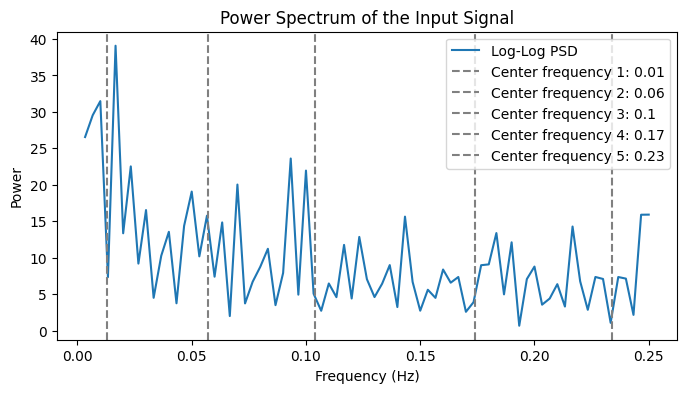

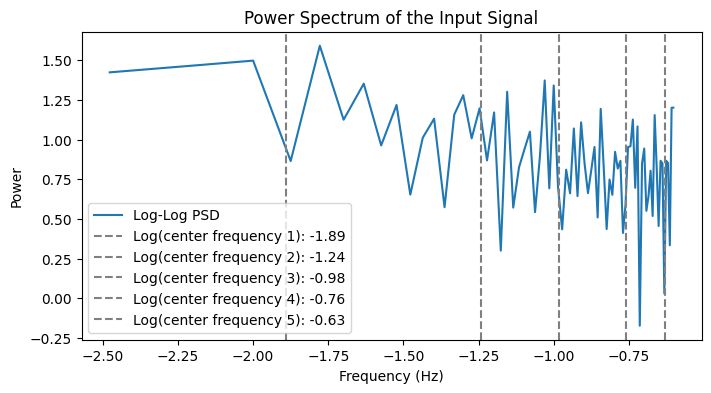

In [13]:
sub = "Vancouver-BCCHR_sub-023"

# time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Barcelona-HCPB_sub-027/Barcelona-HCPB_sub-027.npy")
time_series_data = np.load(f"/pscratch/sd/p/pakmasha/MBBN_data/{sub}/{sub}.npy")
filename = (f"/pscratch/sd/p/pakmasha/MBBN_data/{sub}/{sub}.npy")

# y = time_series_data[20:20+100].T
y = time_series_data.T
ts_length = y.shape[1]
TR = repetition_time(filename)
print(f"TR = {TR}")

nyquist_freq = 1/(2*TR)

# average the time series across ROIs
sample_whole = np.zeros(ts_length,)
intermediate_vec = y.shape[0]

for i in range(intermediate_vec):
    sample_whole+=y[i]

sample_whole /= intermediate_vec 

# VMD setting
f = sample_whole
f = (f - np.mean(f)) / np.std(f)  # z-score normalization
K = 5             # 3 modes
DC = 0             # no DC part imposed
init = 0           # initialize omegas uniformly
tol = 1e-7        # convergence tolerance
alpha = 100
tau = 3.5

# VMD
u, u_hat, omega = VMD(f, alpha, tau, K, DC, init, tol)

import numpy as np

def compute_imf_bandwidths(u, fs, threshold=0.05):
    """
    Compute the bandwidths of IMFs using the Fourier spectrum directly from VMD output.
    
    This version correctly extracts frequency bounds in Hz, avoiding the issue of 
    symmetric zero-centered results.
    
    Parameters:
    u (ndarray): IMFs (shape: K x N, where K is the number of IMFs, N is the time samples).
    fs (float): Sampling frequency of the time series (Hz).
    threshold (float): Power threshold for frequency support (default 1% of max power).

    Returns:
    dict: Band cutoffs in Hz as { 'imf1_lb': ..., 'imf1_hb': ..., ... }
    """
    K, N = u.shape  # Number of IMFs and time samples
    f_N = fs / 2  # Nyquist frequency
    freqs = np.fft.fftfreq(N, d=1/fs)  # Compute frequencies WITHOUT shifting
    positive_freqs = freqs[:N//2]  # Keep only positive frequencies
    band_cutoffs = {}

    for k in range(K):
        # Compute the Fourier Transform of the IMF
        U_k = np.fft.fft(u[k, :])
        power_spectrum = np.abs(U_k) ** 2

        # Normalize power and apply threshold
        power_threshold = threshold * np.max(power_spectrum)
        
        # Extract frequency support only from the positive range
        freq_support = positive_freqs[power_spectrum[:N//2] > power_threshold]

        if len(freq_support) > 0:
            f_min = np.min(freq_support)  # Minimum frequency with significant power
            f_max = np.max(freq_support)  # Maximum frequency with significant power
        else:
            f_min, f_max = 0, 0  # In case no significant power is detected

        # Store the frequency cutoffs
        band_cutoffs[f'imf{k+1}_lb'] = max(0, f_min)  # Ensure non-negative frequencies
        band_cutoffs[f'imf{k+1}_hb'] = min(f_N, f_max)  # Ensure does not exceed Nyquist

        # Print results
        # print(f"IMF {k+1}: Bandwidth = {f_max - f_min:.4f} Hz (Lower: {f_min:.4f} Hz, Upper: {f_max:.4f} Hz)")

    return band_cutoffs


band_cutoffs = compute_imf_bandwidths(u, 1/TR)
print(band_cutoffs)

from scipy.signal import butter, filtfilt
import numpy as np

def bandpass_filter_2d(data, lowcut, highcut, fs, order=4):
    """
    Applies a Butterworth bandpass filter to each ROI in a 2D time-series dataset.
    
    Parameters:
    - data: numpy array of shape (#ROIs, #timepoints), where each row is a time series for one ROI.
    - lowcut: Lower cutoff frequency (Hz).
    - highcut: Upper cutoff frequency (Hz).
    - fs: Sampling frequency (Hz) = 1 / TR.
    - order: Order of the Butterworth filter (default = 4).

    Returns:
    - filtered_data: numpy array of the same shape as 'data' with filtered time series.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist

    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')

    # Apply filter to each ROI (row-wise)
    filtered_data = np.array([filtfilt(b, a, roi_signal) for roi_signal in data])

    return filtered_data


import numpy as np
import matplotlib.pyplot as plt

def plot_power_spectrum(time_series, TR, roi_index=0):
    """
    Plots the power spectrum of the selected ROI.

    Parameters:
    - time_series: numpy array of shape (#ROIs, #timepoints), containing fMRI or other time-series data.
    - TR: Repetition time (sampling interval in seconds).
    - roi_index: Index of the ROI to analyze (default = 0, first ROI).
    """

    # Extract the time-series for the selected ROI
    signal = time_series[roi_index, :]

    # Compute the Fourier Transform
    N = len(signal)  # Number of timepoints
    f_hat = np.fft.fft(signal)  # Compute FFT
    power_spectrum = np.abs(f_hat) ** 2  # Compute power (magnitude squared)

    # Compute frequency axis
    freqs = np.fft.fftfreq(N, d=TR)  # Frequencies in Hz

    # Keep only the positive frequencies
    positive_freqs = freqs[:N // 2]  # First half (positive freqs)
    positive_power = power_spectrum[:N // 2]  # First half (corresponding power)

    # Plot power spectrum
    plt.figure(figsize=(8, 5))
    plt.plot(positive_freqs, positive_power, color='b', linewidth=1.5)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title(f"Power Spectrum of ROI {roi_index}")
    plt.grid(True)
    plt.show()


T = TimeSeries(f, sampling_interval=TR)
print(f"T.shape: {T.shape}")
S_original = SpectralAnalyzer(T)

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

plt.figure(figsize=(8, 4))
plt.plot(xdata, ydata, label="Log-Log PSD")  # Convert to Hz
for k in range(K):
    plt.axvline(x=omega[-1, k] / TR, color='gray', linestyle='--', label=f'Center frequency {k+1}: {np.round(omega[-1, k] / TR, 2)}')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectrum of the Input Signal")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(np.log10(xdata), np.log10(ydata), label="Log-Log PSD")  # Convert to Hz
for k in range(K):
    plt.axvline(x=np.log10(omega[-1, k] / TR), color='gray', linestyle='--', label=f'Log(center frequency {k+1}): {round(np.log10(omega[-1, k] / TR), 2)}')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectrum of the Input Signal")
plt.legend()
plt.show()

In [7]:
print(y.shape[1])
signal_len = y.shape[1]
print(signal_len)
if signal_len % 2:
    signal_len -= 1
print(signal_len)

153
153
152


In [14]:
y = time_series_data.T
ts_length = y.shape[1]
intermediate_vec = y.shape[0]

# VMD parameters
K = 4             # number of modes
DC = 0            # no DC part imposed
init = 0          # initialize omegas uniformly
tol = 1e-7        # convergence tolerance
alpha = 100       # tuned before training based on reconstruction performance
tau = 3.5         # tuned before training based on reconstruction performance

# Initialize IMFs
imf1 = np.zeros((y.shape[0], 700))
imf2 = np.zeros((y.shape[0], 700))
imf3 = np.zeros((y.shape[0], 700))
imf4 = np.zeros((y.shape[0], 700))

roi = 0
f = y[roi,:ts_length] # ROI time series
f = (f - np.mean(f)) / np.std(f)  # z-score normalization
print(f"f.shape: {f.shape}")
print(f"ts_length: {ts_length}")

if len(f)%2:
    f = f[:-1]

# Run actual VMD code
u, _, _ = VMD(f, alpha, tau, K, DC, init, tol)

# add the ROI modes to the total IMFs
imf1[roi, :len(f)] = u[0, :]
imf2[roi, :len(f)] = u[1, :]
imf3[roi, :len(f)] = u[2, :]
imf4[roi, :len(f)] = u[3, :]

print(imf1.shape)
print(imf1[0,:])

imf1 = torch.from_numpy(imf1).T.float()
imf2 = torch.from_numpy(imf2).T.float()
imf3 = torch.from_numpy(imf3).T.float()
imf4 = torch.from_numpy(imf4).T.float()

print("\n", imf1.shape)
print(imf1[1,:])

f.shape: (153,)
ts_length: 153
(316, 700)
[-0.62880546 -0.49890206 -0.31527736 -0.10330682  0.05200442  0.08480502
  0.03838945 -0.07924367 -0.22268644 -0.29706524 -0.26543738 -0.10320225
  0.22919627  0.57043848  0.80155424  0.85253211  0.68347334  0.31594213
 -0.07509756 -0.44539336 -0.66264262 -0.63078866 -0.36240478  0.04062585
  0.43603146  0.623517    0.65893059  0.5918943   0.44293982  0.23157321
  0.05224951 -0.01229899  0.00968674 -0.02382843 -0.1366034  -0.33328312
 -0.48986724 -0.59949265 -0.69534031 -0.76064811 -0.75556355 -0.68192619
 -0.54368562 -0.41544139 -0.28731615 -0.0616931   0.34946197  0.77267452
  0.99568149  1.01700192  0.8654036   0.54810945  0.11190945 -0.32672375
 -0.51217188 -0.38656033 -0.15514773  0.01442895  0.1339383   0.17295285
  0.04548047 -0.24078683 -0.52021272 -0.67041213 -0.65535845 -0.61543124
 -0.60428008 -0.56190365 -0.46868319 -0.33555852 -0.17457825 -0.01056318
  0.15421466  0.29433238  0.28300886  0.11977278 -0.11622135 -0.32235987
 -0.50840

In [3]:
import os
len(os.listdir('/pscratch/sd/p/pakmasha/MBBN_data'))

2094